In [1]:
from deepset import *
MODEL = DeepSet(in_features=5, feats=[80,120,70,50,8], n_class=2,pool="mean") #for full dataset Mean pooling, for small dataset Max pooling
model=MODEL
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device) 


pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean


In [2]:
import torch
from torch.utils.data import Dataset
import pickle
import os
import numpy as np
import random
import pandas as pd

class StreamingHcaDataset(Dataset): 
    def __init__(self, proton_dir, pion_dir, features=["x", "y", "z", "total_energy", "mean_time"]):
        super().__init__()
        
        self.proton_files = sorted([os.path.join(proton_dir, f) for f in os.listdir(proton_dir) if f.endswith(".pkl")])
        self.pion_files = sorted([os.path.join(pion_dir, f) for f in os.listdir(pion_dir) if f.endswith(".pkl")])

        self.features = features
        self.all_files = self.proton_files + self.pion_files  # Combine file lists
        self.labels = [0] * len(self.proton_files) + [1] * len(self.pion_files)  # 0 for proton, 1 for pion

    def __len__(self):
        return len(self.all_files)  # Total number of files

    def _load_file(self, file_path, label):
        """Loads a single pickle file (containing a single DataFrame) and returns point cloud data with labels."""
        # with open(file_path, "rb") as f:
        #     df = pickle.load(f)  # Load single DataFrame
    
        df=pd.read_pickle(file_path)
        # df=pd.read_parquet(file_path,engine='fastparquet')
        df=df[df["total_energy"]>5]
        
          
        part_feat = df[self.features].to_numpy()

        # Handle NaN and Inf values
        part_feat[np.isnan(part_feat)] = 0.0
        part_feat[np.isinf(part_feat)] = 0.0

        return {
            "part": torch.tensor(part_feat, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
            "seq_length": torch.tensor(part_feat.shape[0], dtype=torch.long),
        }

    def __getitem__(self, idx):
        random_idx = random.randint(0, len(self.all_files) - 1)  # Pick a random file
        file_path = self.all_files[random_idx]
        label = self.labels[random_idx]

        return self._load_file(file_path, label)  # Return data from the chosen file


In [3]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """Custom collate function to handle variable-length point cloud data."""
    parts = [item["part"] for item in batch]  # List of tensors (each of shape [N, 5])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)  # Convert list to tensor
    seq_lengths = torch.tensor([item["seq_length"] for item in batch], dtype=torch.long)  # Convert list to tensor

    # Pad variable-length tensors to the longest sequence in the batch
    padded_parts = pad_sequence(parts, batch_first=True, padding_value=0.0)  # Shape [batch_size, max_seq_len, 5]

    return {"part": padded_parts, "label": labels, "seq_length": seq_lengths}


In [4]:
# positron_dir = "/mnt/newdisk/2003_data_pkl/PKL_poistron/PKL_positron"
# proton_dir = "/mnt/newdisk/2003_data_pkl/PKL_proton/PKL_proton"
# positron_dir = "/mnt/c/Users/hnayak/Documents/small_PKL_pion_100GeV_200"
# proton_dir = "/mnt/c/Users/hnayak/Documents/small_PKL_proton_100GeV_200"


pion_dir ="/mnt/c/Users/hnayak/Documents/25GeV/small_PKL_pion_25GeV_100"
proton_dir ="/mnt/c/Users/hnayak/Documents/25GeV/small_PKL_proton_25GeV_100"
name=proton_dir.replace("/mnt/c/Users/hnayak/Documents/25GeV/small_PKL_proton_","")
print(name)
from torch.utils.data import random_split, DataLoader

# Define dataset
train_dataset = StreamingHcaDataset(proton_dir=proton_dir, pion_dir=pion_dir)

# Define split sizes
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure the sum matches total_size

# Split dataset
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=32)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)


print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")



25GeV_100
Train: 160000, Validation: 20000, Test: 20000


In [21]:
import tqdm
def test_model(model, test_loader, criterion=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    correct = 0
    total_samples = 0

    # Progress bar for testing
    test_loader_tqdm = tqdm.tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing")

    with torch.no_grad():
        for i,batch in test_loader_tqdm:
            parts = batch["part"].to(device)         # Input point cloud data
            labels = batch["label"].to(device)  # Labels
            batch_size,seq_len,feat_dim=parts.shape
            parts=parts.cpu().numpy().reshape(-1,feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts=torch.tensor(parts).reshape(batch_size,seq_len,feat_dim).to(device)

            outputs = model(parts)  # Forward pass
            loss = criterion(outputs, labels) if criterion else 0  # Compute loss if provided
            print(labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            test_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar

    avg_loss = total_loss / len(test_loader) if criterion else 0
    accuracy = correct / total_samples * 100

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss , accuracy

In [ ]:
 criterion = nn.CrossEntropyLoss()
 val_loss, Accuracy = test_model(model, val_loader, criterion, device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

def train_model(model, train_loader, val_loader, num_epochs=2, learning_rate=5e-4, device=None, save_path=f"./Models/Z_{name}.pth", log_path=f"./log_summary_Z_{name}.csv"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")  # Initialize best loss

    log_data = []  # To store log info for CSV

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, batch in train_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts = parts.cpu().numpy().reshape(-1, feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts = torch.tensor(parts).reshape(batch_size, seq_len, feat_dim).float().to(device)

            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(parts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        val_loss, Accuracy = test_model(model, val_loader, criterion, device)
         

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save log
        log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": avg_train_loss,
            "Val Loss": val_loss,
            "Accuracy": Accuracy,  # Placeholder for accuracy
        })

        # Save model if validation improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with val loss {val_loss:.4f}")

    # Save the log to CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(log_path, index=False)
    print(f"Training log saved to {log_path}")
    print("Training complete!")


In [7]:

if __name__ == "__main__":
    #Train the model
    train_model(model, train_loader,val_loader=val_loader, num_epochs=60, learning_rate=5e-4, device=device)

Testing: 100%|██████████| 625/625 [00:22<00:00, 27.89it/s, loss=0.535]


Test Loss: 0.6156, Accuracy: 66.31%
Epoch [1/60], Train Loss: 0.6432, Val Loss: 0.6156
Model saved at epoch 1 with val loss 0.6156


Testing: 100%|██████████| 625/625 [00:22<00:00, 28.28it/s, loss=0.621]


Test Loss: 0.5969, Accuracy: 67.97%
Epoch [2/60], Train Loss: 0.6067, Val Loss: 0.5969
Model saved at epoch 2 with val loss 0.5969


Testing: 100%|██████████| 625/625 [00:21<00:00, 28.66it/s, loss=0.622]


Test Loss: 0.5753, Accuracy: 69.91%
Epoch [3/60], Train Loss: 0.5626, Val Loss: 0.5753
Model saved at epoch 3 with val loss 0.5753


Testing: 100%|██████████| 625/625 [00:22<00:00, 28.29it/s, loss=0.639]


Test Loss: 0.5268, Accuracy: 73.20%
Epoch [4/60], Train Loss: 0.5312, Val Loss: 0.5268
Model saved at epoch 4 with val loss 0.5268


Testing: 100%|██████████| 625/625 [00:22<00:00, 28.12it/s, loss=0.402]

Test Loss: 0.5297, Accuracy: 72.88%
Epoch [5/60], Train Loss: 0.5167, Val Loss: 0.5297



Testing: 100%|██████████| 625/625 [00:21<00:00, 28.76it/s, loss=0.478]


Test Loss: 0.4881, Accuracy: 75.58%
Epoch [6/60], Train Loss: 0.5049, Val Loss: 0.4881
Model saved at epoch 6 with val loss 0.4881


Testing: 100%|██████████| 625/625 [00:22<00:00, 28.35it/s, loss=0.547]


Test Loss: 0.4810, Accuracy: 76.72%
Epoch [7/60], Train Loss: 0.4987, Val Loss: 0.4810
Model saved at epoch 7 with val loss 0.4810


Testing: 100%|██████████| 625/625 [00:21<00:00, 29.70it/s, loss=0.53] 

Test Loss: 0.4852, Accuracy: 76.21%
Epoch [8/60], Train Loss: 0.4935, Val Loss: 0.4852



Testing: 100%|██████████| 625/625 [00:21<00:00, 29.13it/s, loss=0.536]


Test Loss: 0.4770, Accuracy: 76.96%
Epoch [9/60], Train Loss: 0.4859, Val Loss: 0.4770
Model saved at epoch 9 with val loss 0.4770


Testing: 100%|██████████| 625/625 [00:21<00:00, 29.02it/s, loss=0.619]

Test Loss: 0.4837, Accuracy: 76.26%
Epoch [10/60], Train Loss: 0.4819, Val Loss: 0.4837



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.69it/s, loss=0.41] 


Test Loss: 0.4680, Accuracy: 77.32%
Epoch [11/60], Train Loss: 0.4792, Val Loss: 0.4680
Model saved at epoch 11 with val loss 0.4680


Testing: 100%|██████████| 625/625 [00:21<00:00, 28.47it/s, loss=0.323]

Test Loss: 0.4753, Accuracy: 76.94%
Epoch [12/60], Train Loss: 0.4757, Val Loss: 0.4753



Testing: 100%|██████████| 625/625 [00:21<00:00, 29.45it/s, loss=0.382]


Test Loss: 0.4543, Accuracy: 78.18%
Epoch [13/60], Train Loss: 0.4738, Val Loss: 0.4543
Model saved at epoch 13 with val loss 0.4543


Testing: 100%|██████████| 625/625 [00:22<00:00, 27.94it/s, loss=0.56] 


Test Loss: 0.4475, Accuracy: 78.48%
Epoch [14/60], Train Loss: 0.4753, Val Loss: 0.4475
Model saved at epoch 14 with val loss 0.4475


Testing: 100%|██████████| 625/625 [00:21<00:00, 29.54it/s, loss=0.621]

Test Loss: 0.4666, Accuracy: 77.11%
Epoch [15/60], Train Loss: 0.4716, Val Loss: 0.4666



Testing: 100%|██████████| 625/625 [00:20<00:00, 31.16it/s, loss=0.43] 

Test Loss: 0.4597, Accuracy: 77.68%
Epoch [16/60], Train Loss: 0.4690, Val Loss: 0.4597



Testing: 100%|██████████| 625/625 [00:20<00:00, 31.11it/s, loss=0.692]

Test Loss: 0.4677, Accuracy: 77.50%
Epoch [17/60], Train Loss: 0.4659, Val Loss: 0.4677



Testing: 100%|██████████| 625/625 [00:20<00:00, 31.23it/s, loss=0.672]


Test Loss: 0.4460, Accuracy: 78.50%
Epoch [18/60], Train Loss: 0.4639, Val Loss: 0.4460
Model saved at epoch 18 with val loss 0.4460


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.58it/s, loss=0.496]

Test Loss: 0.4579, Accuracy: 77.56%
Epoch [19/60], Train Loss: 0.4640, Val Loss: 0.4579



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.68it/s, loss=0.403]


Test Loss: 0.4524, Accuracy: 78.20%
Epoch [20/60], Train Loss: 0.4607, Val Loss: 0.4524


Testing: 100%|██████████| 625/625 [00:20<00:00, 31.24it/s, loss=0.454]

Test Loss: 0.4859, Accuracy: 76.51%
Epoch [21/60], Train Loss: 0.4613, Val Loss: 0.4859



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.61it/s, loss=0.362]

Test Loss: 0.4492, Accuracy: 78.36%
Epoch [22/60], Train Loss: 0.4593, Val Loss: 0.4492



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.59it/s, loss=0.351]

Test Loss: 0.4761, Accuracy: 76.95%
Epoch [23/60], Train Loss: 0.4556, Val Loss: 0.4761



Testing: 100%|██████████| 625/625 [00:19<00:00, 32.17it/s, loss=0.494]

Test Loss: 0.4532, Accuracy: 78.27%
Epoch [24/60], Train Loss: 0.4594, Val Loss: 0.4532



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.69it/s, loss=0.415]

Test Loss: 0.4751, Accuracy: 76.78%
Epoch [25/60], Train Loss: 0.4515, Val Loss: 0.4751



Testing: 100%|██████████| 625/625 [00:20<00:00, 31.16it/s, loss=0.461]


Test Loss: 0.4401, Accuracy: 78.64%
Epoch [26/60], Train Loss: 0.4558, Val Loss: 0.4401
Model saved at epoch 26 with val loss 0.4401


Testing: 100%|██████████| 625/625 [00:19<00:00, 32.20it/s, loss=0.463]

Test Loss: 0.5108, Accuracy: 74.30%
Epoch [27/60], Train Loss: 0.4556, Val Loss: 0.5108



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.50it/s, loss=0.53] 

Test Loss: 0.4406, Accuracy: 78.86%
Epoch [28/60], Train Loss: 0.4535, Val Loss: 0.4406



Testing: 100%|██████████| 625/625 [00:19<00:00, 32.03it/s, loss=0.591]

Test Loss: 0.4528, Accuracy: 78.08%
Epoch [29/60], Train Loss: 0.4520, Val Loss: 0.4528



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.81it/s, loss=0.413]

Test Loss: 0.4607, Accuracy: 77.67%
Epoch [30/60], Train Loss: 0.4552, Val Loss: 0.4607



Testing: 100%|██████████| 625/625 [00:19<00:00, 32.15it/s, loss=0.447]

Test Loss: 0.4893, Accuracy: 75.52%
Epoch [31/60], Train Loss: 0.4504, Val Loss: 0.4893



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.75it/s, loss=0.736]

Test Loss: 0.5044, Accuracy: 75.06%
Epoch [32/60], Train Loss: 0.4491, Val Loss: 0.5044



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.36it/s, loss=0.668]

Test Loss: 0.4464, Accuracy: 78.77%
Epoch [33/60], Train Loss: 0.4509, Val Loss: 0.4464



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.90it/s, loss=0.537]

Test Loss: 0.4403, Accuracy: 79.16%
Epoch [34/60], Train Loss: 0.4479, Val Loss: 0.4403



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.75it/s, loss=0.54] 


Test Loss: 0.4514, Accuracy: 77.70%
Epoch [35/60], Train Loss: 0.4469, Val Loss: 0.4514


Testing: 100%|██████████| 625/625 [00:20<00:00, 31.15it/s, loss=0.307]


Test Loss: 0.4477, Accuracy: 78.43%
Epoch [36/60], Train Loss: 0.4448, Val Loss: 0.4477


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.80it/s, loss=0.306]


Test Loss: 0.4351, Accuracy: 78.95%
Epoch [37/60], Train Loss: 0.4484, Val Loss: 0.4351
Model saved at epoch 37 with val loss 0.4351


Testing: 100%|██████████| 625/625 [00:20<00:00, 30.75it/s, loss=0.246]


Test Loss: 0.4398, Accuracy: 78.90%
Epoch [38/60], Train Loss: 0.4445, Val Loss: 0.4398


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.55it/s, loss=0.223]

Test Loss: 0.4470, Accuracy: 78.52%
Epoch [39/60], Train Loss: 0.4444, Val Loss: 0.4470



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.75it/s, loss=0.374]


Test Loss: 0.4314, Accuracy: 79.59%
Epoch [40/60], Train Loss: 0.4457, Val Loss: 0.4314
Model saved at epoch 40 with val loss 0.4314


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.42it/s, loss=0.417]


Test Loss: 0.4390, Accuracy: 78.89%
Epoch [41/60], Train Loss: 0.4467, Val Loss: 0.4390


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.95it/s, loss=0.251]

Test Loss: 0.5121, Accuracy: 75.23%
Epoch [42/60], Train Loss: 0.4445, Val Loss: 0.5121



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.41it/s, loss=0.336]


Test Loss: 0.4332, Accuracy: 79.48%
Epoch [43/60], Train Loss: 0.4441, Val Loss: 0.4332


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.72it/s, loss=0.587]

Test Loss: 0.4425, Accuracy: 79.04%
Epoch [44/60], Train Loss: 0.4412, Val Loss: 0.4425



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.61it/s, loss=0.421]

Test Loss: 0.4362, Accuracy: 79.50%
Epoch [45/60], Train Loss: 0.4397, Val Loss: 0.4362



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.77it/s, loss=0.418]


Test Loss: 0.4278, Accuracy: 79.61%
Epoch [46/60], Train Loss: 0.4390, Val Loss: 0.4278
Model saved at epoch 46 with val loss 0.4278


Testing: 100%|██████████| 625/625 [00:19<00:00, 31.55it/s, loss=0.369]

Test Loss: 0.4425, Accuracy: 78.52%
Epoch [47/60], Train Loss: 0.4428, Val Loss: 0.4425



Testing: 100%|██████████| 625/625 [00:18<00:00, 33.36it/s, loss=0.393]

Test Loss: 0.4350, Accuracy: 79.23%
Epoch [48/60], Train Loss: 0.4387, Val Loss: 0.4350



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.49it/s, loss=0.476]


Test Loss: 0.4277, Accuracy: 79.73%
Epoch [49/60], Train Loss: 0.4396, Val Loss: 0.4277
Model saved at epoch 49 with val loss 0.4277


Testing: 100%|██████████| 625/625 [00:20<00:00, 30.67it/s, loss=0.466]

Test Loss: 0.4350, Accuracy: 79.34%
Epoch [50/60], Train Loss: 0.4378, Val Loss: 0.4350



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.63it/s, loss=0.446]

Test Loss: 0.4297, Accuracy: 79.88%
Epoch [51/60], Train Loss: 0.4378, Val Loss: 0.4297



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.63it/s, loss=0.435]

Test Loss: 0.4299, Accuracy: 79.47%
Epoch [52/60], Train Loss: 0.4362, Val Loss: 0.4299



Testing: 100%|██████████| 625/625 [00:20<00:00, 31.21it/s, loss=0.543]


Test Loss: 0.4229, Accuracy: 80.25%
Epoch [53/60], Train Loss: 0.4391, Val Loss: 0.4229
Model saved at epoch 53 with val loss 0.4229


Testing: 100%|██████████| 625/625 [00:21<00:00, 28.45it/s, loss=0.709]

Test Loss: 0.4331, Accuracy: 79.50%
Epoch [54/60], Train Loss: 0.4384, Val Loss: 0.4331



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.87it/s, loss=0.391]

Test Loss: 0.4363, Accuracy: 78.97%
Epoch [55/60], Train Loss: 0.4381, Val Loss: 0.4363



Testing: 100%|██████████| 625/625 [00:20<00:00, 29.78it/s, loss=0.448]

Test Loss: 0.4342, Accuracy: 79.63%
Epoch [56/60], Train Loss: 0.4346, Val Loss: 0.4342



Testing: 100%|██████████| 625/625 [00:22<00:00, 27.50it/s, loss=0.593]

Test Loss: 0.4432, Accuracy: 78.66%
Epoch [57/60], Train Loss: 0.4367, Val Loss: 0.4432



Testing: 100%|██████████| 625/625 [00:21<00:00, 28.53it/s, loss=0.348]

Test Loss: 0.4635, Accuracy: 77.69%
Epoch [58/60], Train Loss: 0.4355, Val Loss: 0.4635



Testing: 100%|██████████| 625/625 [00:20<00:00, 30.22it/s, loss=0.54] 

Test Loss: 0.4316, Accuracy: 79.58%
Epoch [59/60], Train Loss: 0.4345, Val Loss: 0.4316



Testing: 100%|██████████| 625/625 [00:21<00:00, 29.11it/s, loss=0.415]


Test Loss: 0.4277, Accuracy: 79.52%
Epoch [60/60], Train Loss: 0.4343, Val Loss: 0.4277
Training log saved to ./log_summary_Z_{name}.csv
Training complete!


In [23]:
model_test = MODEL
model_test.load_state_dict(torch.load(f"./Models/Z_{name}.pth",weights_only=True))
model_test.to(device)

DeepSet(
  (sequential): ModuleList(
    (0): DeepSetLayer(
      (Gamma): Linear(in_features=5, out_features=80, bias=True)
      (Lambda): Linear(in_features=5, out_features=80, bias=True)
      (bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): DeepSetLayer(
      (Gamma): Linear(in_features=80, out_features=120, bias=True)
      (Lambda): Linear(in_features=80, out_features=120, bias=True)
      (bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): DeepSetLayer(
      (Gamma): Linear(in_features=120, out_features=70, bias=True)
      (Lambda): Linear(in_features=120, out_features=70, bias=True)
      (bn): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): DeepSetLayer(
      (Gamma): Linear(in_features=70, out_features=5

In [24]:
total_params = sum(p.numel() for p in MODEL.parameters())
print(total_params)

45292


In [17]:
def evaluate_model(model, data_loader, criterion, device, return_accuracy=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    data_loader_tqdm = tqdm(enumerate(data_loader), desc="Testing",total=len(data_loader))
    with torch.no_grad():
        for i,batch in data_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size,seq_len,feat_dim=parts.shape
            parts=parts.cpu().numpy().reshape(-1,feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts=torch.tensor(parts).reshape(batch_size,seq_len,feat_dim).to(device)
            labels = batch["label"].to(device)
            
            outputs = model(parts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            if return_accuracy:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total if return_accuracy else None
    
    return (avg_loss, f"{accuracy}%") if return_accuracy else avg_loss

In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import beta

def evaluate_model(model, data_loader, criterion, device, name="model", return_accuracy=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    data_loader_tqdm = tqdm.tqdm(enumerate(data_loader), desc="Testing", total=len(data_loader))
    
    true_labels = []
    pred_labels = []
    all_scores = []

    with torch.no_grad():
        for i, batch in data_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts_np = parts.cpu().numpy().reshape(-1, feat_dim)

            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts_np = qt.fit_transform(parts_np)
            parts = torch.tensor(parts_np).reshape(batch_size, seq_len, feat_dim).to(device)

            labels = batch["label"].to(device)
            outputs = model(parts)
            preds = F.softmax(outputs, dim=1)

            # Collect soft scores for the positive class (class 1)
            all_scores.extend(preds[:, 1].detach().cpu().numpy())
            pred_labels.extend(torch.argmax(preds, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            if return_accuracy:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total if return_accuracy else None

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    colors = ["#cce5ff", "#004c99"]
    cmap = LinearSegmentedColormap.from_list("Custom Blue", colors)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Proton", "Pion"], yticklabels=["Proton", "Pion"],
                annot_kws={"size": 18, "weight": "bold"})
    
    TP, FN = cm[0, 0], cm[0, 1]
    FP, TN = cm[1, 0], cm[1, 1]
    n_total = TP + TN + FP + FN
    n_correct = TP + TN
    alpha = 0.32

    lower_bound = beta.ppf(alpha / 2, n_correct, n_total - n_correct + 1)
    upper_bound = beta.ppf(1 - alpha / 2, n_correct + 1, n_total - n_correct)
    
    title = f"Accuracy: {accuracy:.2f}%, 68% CI: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]"
    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel('Predicted', size=14, weight='bold')
    plt.ylabel('True', size=14, weight='bold')
    plt.xticks(size=14, weight='bold')
    plt.yticks(size=14, weight='bold')
    plt.savefig(f"./plots/confusion_matrix_{name}.pdf", dpi=300, bbox_inches='tight')
    print(f"Confusion Matrix:\n{cm}")
    print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

    # ROC Curve
    y_true = np.array(true_labels)
    y_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    N_x = sum(y_true == 0)
    N_y = sum(y_true == 1)
    sigma_fpr = np.sqrt(fpr * (1 - fpr) / N_x)
    sigma_tpr = np.sqrt(tpr * (1 - tpr) / N_y)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.fill_between(fpr, tpr - 5 * sigma_tpr, tpr + 5 * sigma_tpr,
                     color='blue', alpha=0.25, label='1-sigma region (PiPR) [5x]')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate (Proton)', fontsize=12)
    plt.ylabel('True Positive Rate (Pion)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(f"./plots/roc_curve_{name}.pdf")

    return (avg_loss, f"{accuracy:.2f}%") if return_accuracy else avg_loss



Testing: 100%|██████████| 625/625 [00:19<00:00, 31.90it/s]


Confusion Matrix:
[[8178 1820]
 [2136 7866]]
95% Confidence Interval: [0.7994, 0.8050]


(0.428120023560524, '80.22%')

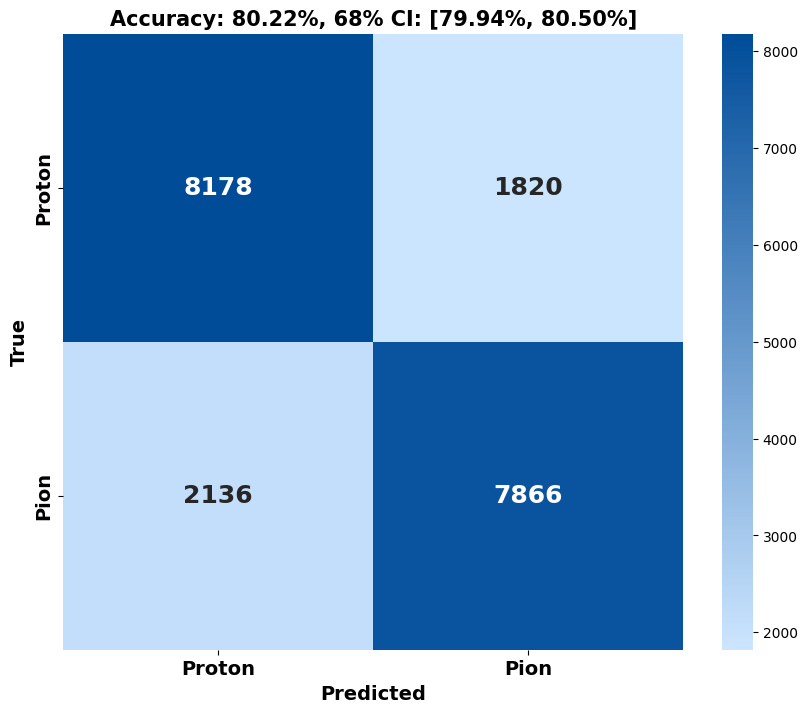

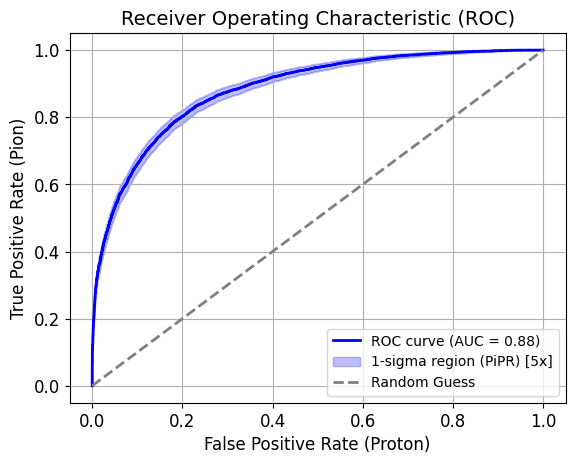

In [28]:
evaluate_model(model_test, test_loader, nn.CrossEntropyLoss(), device, return_accuracy=True)